In [36]:
import itertools as its
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

In [37]:
def get_GO_gene_counts(input_file):
    counts_dict = {}
    counts_file = open(input_file)
    for (i, line) in enumerate(counts_file):
        if i < 2:
            continue
        data = line.rstrip().split('\t')
        counts_dict[data[0]] = int(data[1])
    counts_file.close()
    return counts_dict

# This funtion produces a dictionary that maps each given GO term to a tissue in GTEX (via BTO)
def map_GO_to_GTEX(GO_list):
    inputFilename = '../data/Tissue_Name_Mappings.csv'
    tissue_data = pd.read_csv(inputFilename,header=None)
    map_BTO_to_GTEX = defaultdict(list)

    for index,row in tissue_data.iterrows():
        GTEX_tissue = row[0]
        BTO_tissues = row[1:]
        for tissue in BTO_tissues.dropna():
            map_BTO_to_GTEX[tissue].append(GTEX_tissue)
    
    inputFilename = '../data/BTO_GO.csv'
    BTO_data = pd.read_csv(inputFilename,skiprows=[0])
    map_GO_to_GTEX = defaultdict(list)

    for index,row in BTO_data.iterrows():
        tissue = row[1]
        if tissue in map_BTO_to_GTEX:
            GO_IDs = row[2:]
            for GO_ID in GO_IDs.dropna():
                if GO_ID in GO_list:
                    map_GO_to_GTEX[GO_ID] = map_GO_to_GTEX[GO_ID] + map_BTO_to_GTEX[tissue]

    return map_GO_to_GTEX

In [38]:
# Get tissue for each coefficient
inputFilename = '../data/samples_to_tissues_map.txt'
sample_file = open(inputFilename)
sample_list = np.loadtxt(sample_file,skiprows=1,usecols=[2],dtype='S40',delimiter='\t')
tissue_types = np.unique(sample_list)
sample_file.close()

# Get list of GO_IDs
inputFilename = '../data/GO_terms_final_gene_counts.txt'
GO_list_file = open(inputFilename)
GO_list = np.loadtxt(GO_list_file,skiprows=2,usecols=[0],dtype='S10',delimiter='\t')
GO_list_file.close()

# Create dataframe to of binary tissue firing matrix
tissue_firing = pd.DataFrame(1e-8, columns=GO_list, index=tissue_types)

# Iterate through GO_ID files
for GO_ID in GO_list:
    inputFilename = '../GO_prediction/results_all_tissues/logreg_' + GO_ID + '.txt'
    results = open(inputFilename)
    nextline = 0
    for line in results:
        data = line.split()
        if nextline == 1:
            coeffs = np.array(data,dtype='float')
            results.close()
            break
        if data[1] == 'Coefficients:':
            nextline = 1
            continue
    # index of non-zero coefficients
    idx = np.where(abs(coeffs) > 1e-7)[0]

    # tissues that have non-zero coefficients
    non_zero_tissues = np.unique(sample_list[idx])
    for tissue in non_zero_tissues:
        tissue_firing[GO_ID][tissue] = 1

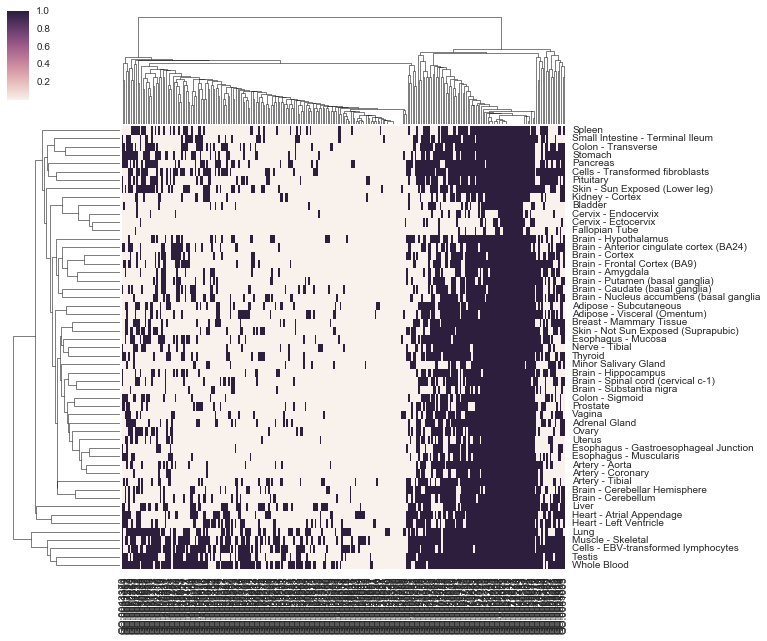

In [39]:
# Clustering heatmap of fired tissues
cluster = sns.clustermap(tissue_firing,metric='jaccard')
sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()

In [40]:
# WITH FILTERING BY GENE COUNT

gene_counts = get_GO_gene_counts('../data/GO_terms_final_gene_counts.txt')
GO_list_filtered = [ID for ID in GO_list if gene_counts[ID] >= 30]

# Create dataframe of binary tissue firing matrix
tissue_firing_filtered = pd.DataFrame(1e-8, columns=GO_list_filtered, index=tissue_types)

# Iterate through GO_ID files
for GO_ID in GO_list_filtered:
    inputFilename = '../GO_prediction/results_all_tissues/logreg_' + GO_ID + '.txt'
    results = open(inputFilename)
    nextline = 0
    for line in results:
        data = line.split()
        if nextline == 1:
            coeffs = np.array(data,dtype='float')
            results.close()
            break
        if data[1] == 'Coefficients:':
            nextline = 1
            continue
    # index of non-zero coefficients
    idx = np.where(abs(coeffs) > 1e-7)[0]

    # tissues that have non-zero coefficients
    non_zero_tissues = np.unique(sample_list[idx])
    for tissue in non_zero_tissues:
        tissue_firing_filtered[GO_ID][tissue] = 1

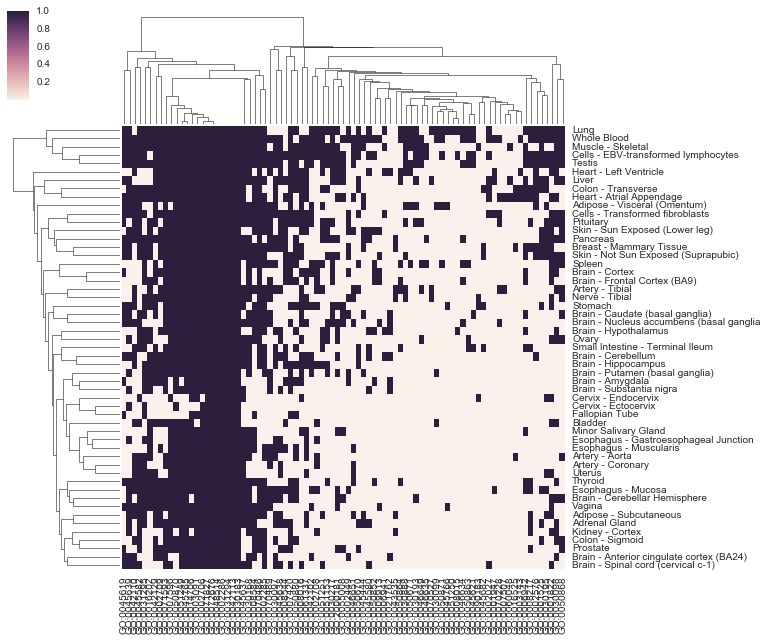

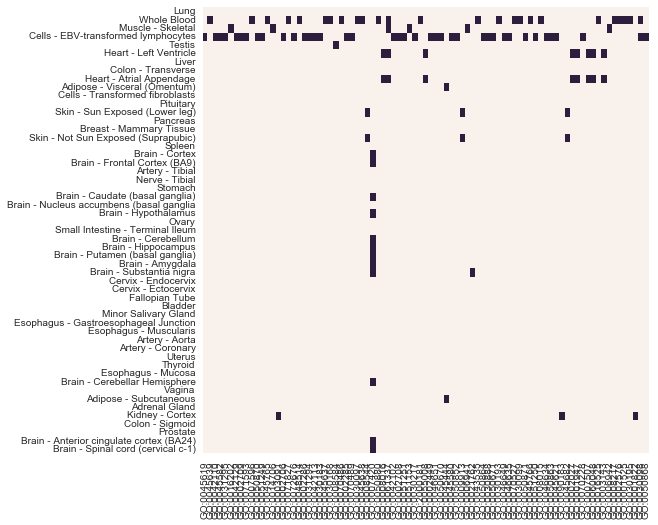

In [41]:
# Clustering heatmap of fired tissues
cluster_filtered = sns.clustermap(tissue_firing_filtered,metric='jaccard')
sns.plt.setp(cluster_filtered.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()


# Heatmap showing relationship between GO terms and tissues
GO_list_ordered = [GO_list_filtered[ind] for ind in cluster_filtered.dendrogram_col.reordered_ind]
tissues_ordered = [tissue_types[ind] for ind in cluster_filtered.dendrogram_row.reordered_ind]
relation_matrix = pd.DataFrame(0, columns=GO_list_ordered, index=tissues_ordered)

GO_to_tissue = map_GO_to_GTEX(GO_list_ordered)
for GO_ID in GO_list_ordered:
    for tissue in tissues_ordered:
        if tissue in GO_to_tissue[GO_ID]:
            relation_matrix[GO_ID][tissue] = 1

fig = plt.figure(figsize=(8,8))
relation_map = sns.heatmap(relation_matrix,cbar=False)
sns.plt.show()

(array([ 24464.,   5508.,   2065.,   1075.,    608.,    349.,    190.,
           149.,    115.,     72.]),
 array([  9.45863393e-07,   9.98057413e-02,   1.99610537e-01,
          2.99415332e-01,   3.99220128e-01,   4.99024923e-01,
          5.98829718e-01,   6.98634514e-01,   7.98439309e-01,
          8.98244105e-01,   9.98048900e-01]),
 <a list of 10 Patch objects>)

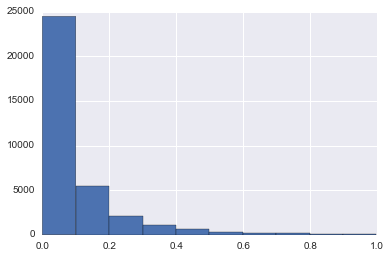

In [42]:
# HISTOGRAM OF COEFFICIENT MAGNITUDES FROM HIGH-GENE GO TERMS
all_coeffs = []
for GO_ID in GO_list_filtered:
    inputFilename = '../GO_prediction/results_all_tissues/logreg_' + GO_ID + '.txt'
    results = open(inputFilename)
    nextline = 0
    for line in results:
        data = line.split()
        if nextline == 1:
            coeffs = np.array(data,dtype='float')
            non_zeros = [abs(coeff) for coeff in coeffs if abs(coeff) > 1e-7]
            zero_to_one = [val for val in non_zeros if val < 1]
            all_coeffs = np.concatenate((all_coeffs,zero_to_one))
            results.close()
            break
        if data[1] == 'Coefficients:':
            nextline = 1
            continue
plt.hist(all_coeffs)